In [5]:
!pip install hyppo
import import

In [6]:
torch.cuda.is_available()

True

In [7]:
import os
os.getcwd()

'/mnt/batch/tasks/shared/LS_root/mounts/clusters/better-1-gpu/code'

In [92]:
# imports
from scipy.stats import multiscale_graphcorr as MGC
import scipy
import numpy as np
import torch
import matplotlib.pyplot as plt
from inspect import getmembers
import inspect
import warnings

import sys
from pathlib import Path
import pickle
import glob

sys.path.append('//home/azureuser/MGC_classifier/source')
import shape_functions


https://stackoverflow.com/questions/43729052/generator-function-yield-much-faster-then-iterator-class-next
Explains what type of function/generator to use for performance

In [89]:
!ls //home/azureuser/MGC_classifier/source

__pycache__	   mgc_adversary.py   shape_functions.py
dataset_loader.py  mgc_classifier.py  training_script.py


In [79]:
os.getcwd()

'/mnt/batch/tasks/shared/LS_root/mounts/clusters/better-1-gpu/code'

a
0 0

NameError: name 'y_temp' is not defined

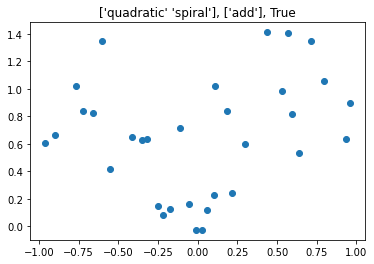

In [69]:
class function_generator:
    def __init__(self, sample_size=32, output_size=32):
        
        # the size of the samples that go through MGC
        self.SIZE = sample_size
        # the size of the samples that actually come out
        # of the generator through interpolating
        self.output_size = output_size

        self.operations = [
            "multiply",
            "divide",
            "add",
            "subtract",
        ]

        self.hyppo_functions = [
            "linear",
            "exponential",
            "cubic",
            "joint_normal",
            "step",
            "quadratic",
            "w_shaped",
            "spiral",
            "logarithmic",
            "fourth_root",
            "sin_four_pi",
            "sin_sixteen_pi",
            "square",
            "two_parabolas",
            "circle",
            "ellipse",
            "diamond",
            "multiplicative_noise",
            "multimodal_independence",
        ]

        # two term operations
        self.two_term_operations = ["multiply", "divide"]

        # TODO adding and subtracting new terms
        self.add_term_operations = ["add", "subtract"]

        # check if all operations are contained in the other sets
        assert set(self.two_term_operations).union(
            set(self.add_term_operations)
        ) == set(self.operations)

        self.sample_size = sample_size

        self.operation_scale_dict = {
            "arccos": (-0.99, 0.99),
            "arccosh": (1.01, 10),
            "arcsin": (-0.99, 0.99),
            "arcsinh": (-np.pi, np.pi),
            "arctan": (-3, 3),
            "arctan2": ((-0.99, 0.99), (-0.99, 0.99)),
            "arctanh": (-0.99, 0.99),
            "heaviside": ((-0.99, 0.99), (-0.99, 0.99)),
            "log": (0.01, 3),
            "log10": (0.01, 3),
            "log1p": (0.01, 3),
            "log2": (0.01, 3),
            "multiply": ((-1, 1), (-1, 1)),
            "sin": (-np.pi, np.pi),
            "sinh": (-3, 3),
            "sqrt": (0, 1),
            "square": (-1, 1),
            "tan": (-np.pi / 2 + 0.01, np.pi / 2 - 0.01),
            "tanh": (-np.pi, np.pi),
            "divide": ((-2, 2), (0.01, 2)),
            "subtract": (-1, 1),
            "add": (-1, 1),
        }

        self.samples_dict = {}

    def yield_sample(self, a, b, p):
        """calls the other methods to yield samples lazily"""
        while True:

            # this controls how many successive operations are going
            n_functions = np.random.choice([1, 2, 3])

            # get a random set of functions but make sure they are mixable
            functions = None
            while functions is None or \
                functions:
            functions = np.random.choice(self.hyppo_functions, size = n_functions)

            # start a dictionary to store values
            funct_dict = {}

            # get the values for these functions
            for i, function in enumerate(functions):
                # get function and noise
                funct = getattr(hyppo.tools, function)
                noise = bool(np.random.choice([True, False], p=[0.3, 0.7]))
                # handle passing x to ensure that xs are the same
                if i==0:
                    x = None
                if function in ["multiplicative_noise", "multimodal_independence"]:
                    x, y = funct(self.sample_size, 1)
                    funct_dict[function] = {
                        'x':x,
                        'y':y
                    }

                elif function in ["linear","exponential","cubic", "step","quadratic", 
                                "w_shaped", "spiral", "fourth_root", "sin_four_pi", 
                                "sin_sixteen_pi","square", "circle", 
                                "ellipse", "diamond"]:
                    x, y = funct(self.SIZE,1, noise=noise, low=min(a,b), high=max(a,b), x=x)
                    funct_dict[function] = {
                        'x':x,
                        'y':y
                    }
                
                elif function =="two_parabolas":
                    x, y = funct(self.SIZE,1, noise=noise, low=min(a,b), high=max(a,b), 
                                prob=p, x=x)
                    funct_dict[function] = {
                        'x':x,
                        'y':y
                    }
                    
                elif function == 'uncorrelated_bernoulli':
                    x, y = funct(self.SIZE,1, noise=noise, prob=p)
                    funct_dict[function] = {
                        'x':x,
                        'y':y
                    }

                elif function in ["joint_normal", "logarithmic"]:
                    x, y = funct(self.SIZE,1, noise=noise)
                    funct_dict[function] = {
                        'x':x,
                        'y':y
                    }
                
                elif function == 'multimodal_independence':
                    x, y = funct(self.SIZE,1, prob=p, sep1=a, sep2=b)
                    funct_dict[function] = {
                        'x':x,
                        'y':y
                    }

            # store the operations for targets
            n_operations = n_functions-1
            order_of_operations = np.random.choice(self.operations, size = n_operations)

            # initialize a list for the terms
            terms = []
            x, y = None, None
            for i, function in enumerate(functions):

                if (x is None) or (y is None):
                    x = funct_dict[function]['x']
                    y = funct_dict[function]['y']
                    
                    # sort arrays
                    sorting_index = x.squeeze().argsort()
                    x = x[sorting_index].squeeze()
                    y = y[sorting_index].squeeze()
                else:
                    # get the actual function with this operator
                    operator = order_of_operations[i-1]
                    funct = getattr(np, operator)
                    
                    # get the new values
                    x_new = funct_dict[function]['x']
                    y_new = funct_dict[function]['y']
                    
                    # problem: they don't have the same x values
                    # this should always add some noise. The new x will 
                    # be the average between the xs
                    sorting_index = x_new.squeeze().argsort()
                    x_new = x_new[sorting_index].squeeze()
                    y_new = y_new[sorting_index].squeeze()

                    # average  for x
                    x = (x + x_new ) / 2

                    # new value for y
                    y = funct(y,y_new)
            
            
            plt.plot(x, y, 'o')
            plt.title(f'{functions}, {order_of_operations}, {noise}')



                

            self.terms = terms


            # plt.plot(x, np.array(terms).T)

            y = y_temp
            # plt.plot(x, y, 'ro', markersize=2)
            # plt.pause(0.001)

            yield (x, y), order_of_operations

    def generate_MGC_maps(self, n_samples, generator_parameters):

        a, b, p = generator_parameters
        # temporary
        a,b,p = -1,1,0.5
        # instantiate the generator
        gen = self.yield_sample(a,b,p)

        labels = []
        # generate the data
        for i in range(n_samples):
            print(f"\r{i} {len(self.samples_dict)}", end="")
            (x, y), label = next(gen)
            labels.append(label)
            try:
                if not any(np.isnan(y)):
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore")
                        _, _, MGC_DICT = MGC(x, y, reps=0, workers=-1)
                        fig, axs = plt.subplots(1,2)
                        axs[0].imshow(MGC_DICT["mgc_map"])
                        axs[0].set_title(label)
                        axs[0].invert_yaxis()
                        axs[1].twinx()
                        axs[1].plot(x, y, 'ro', markersize=2)
                        plt.pause(0.001)

                    self.samples_dict[i] = (MGC_DICT["mgc_map"], (x, y), label)
                    dict_size = get_size(self.samples_dict)
                    if dict_size > 10e6:
                        print(dict_size)
                        path = Path("data")
                        num = len(list(path.glob("*")))

                        with open(Path(path, str(num) + ".pkl"), "wb") as fp:
                            pickle.dump(self.samples_dict, fp)

                        self.samples_dict = {}

            except IndexError:
                pass


print("a")
class_instance = function_generator(32)
a_test,b_test,p_test = -1,1,0.5
generator = class_instance.yield_sample(a_test,b_test,p_test)
class_instance.generate_MGC_maps(7, (a_test,b_test,p_test))

# should be around 12 gb of data ofr 100,000 samples


In [74]:
bool(set([1,2,3]).intersection(set([4,5,6, 1])))

True

In [75]:
torch.cuda.is_available()

True

## save the configurations for the hyppo.tools operators if I want to refine this later

`if operator in ['multiplicative','multimodal_independence']:
        noise = False
      else:
        noise = False

      if operator in ["linear","exponential","cubic", "step","quadratic", 
                      "w_shaped", "spiral", "fourth_root", "sin_four_pi", 
                      "sin_sixteen_pi","square", "circle", 
                      "ellipse", "diamond"]:
        x, y = funct(self.SIZE,1, noise=noise, low=min(a,b), high=max(a,b))
      
      elif operator =="two_parabolas":
        x, y = funct(self.SIZE,1, noise=noise, low=min(a,b), high=max(a,b), 
                     prob=np.random.random())
        
      elif operator == 'uncorrelated_bernoulli':
        x, y = funct(self.SIZE,1, noise=noise, prob=np.random.random())

      elif operator in ["joint_normal", "logarithmic"]:
        x, y = funct(self.SIZE,1, noise=noise)
      
      elif operator == 'multimodal_independence':
        x, y = funct(self.SIZE,1, prob=np.random.random(), sep1=a, sep2=b)

      elif operator == 'multiplicative':
        x, y = funct(self.SIZE,1)`